# Exercise : Implement a Neural Network from Scratch

Exercise Taken from : CS 437 - Deep Learning - LUMS



In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from IPython.display import Image
import pydot
from tqdm import tqdm_notebook

# from class_tests import test_neural_network

from sklearn.datasets import make_moons
from sklearn.linear_model import LinearRegression, LogisticRegression

In this exercise you will be creating 4 versions of the `NeuralNetwork` class. You will start with a simple 2 layer feed forward network and progressively modify the class by adding features to make it more generic. At the end you will have implemented a version which can create networks of arbitrary shape and depth, and which will work for both regression and classification tasks. 

Often in pratical situations, raw machine learning architecture and code is hidden behind libraries and simplfied toolkits. The purpose of this assignment is to lift that curtain and get you hands-on exprience working with the mathematical fundamentals of neural network architectures. After this, you'll know exactly how a network leverages 'gradient descent' to find optimal solutions and how forward and backward passes are implemented mathematically and in code.


### Primary Task
Skeleton code is provided to get you started; the main methods you need to implement correspond to the 3 steps of the training process, namely:
1. Initialize variables and initialize weights
2. Forward pass
3. Backward pass AKA Backpropogation
4. Weight Update AKA Gradient Descent

A `fit` function is what combines the previous three functions and overall trains the network to __fit__ to the provided training examples. In all the following tasks, the provided `fit` methods require the three steps of the training process to be correctly working. The function has been setup in a way that it expects the above 3 methods to take particular inputs and return particular outputs. __You are supposed to work within this restriction.__ Modification of the provided code without prior discussion with the TAs will result in a __grade deduction__. 

### Support code
The class comes with a few useful methods for the activation functions, plotting and model error evaluation. Here are some points to note:
1. Test cases have been provided for the functions (methods) you need to implement. 
2. These test cases are present in a separate python script but you will only need to use a function imported into this notebook to leverage them (usage is shown in each task). 
3. The test cases will check the 3 individual functions you will have written and but not the overall model that they fit into. 
4. The test cases expect you to implement stochastic gradient descent (and __not__ the other two implementations).
5. The test cases are __not__ exhaustive so they do not guarantee that your solution is 100% correct. For that you should always look at the loss plot during training.

To see how well your model is doing, you need to look at the dummy tasks (at the end) and make sure your model loss is going down during training. A dummy regression task of adding two numbers (sum less than 1) has been provided as well. Similarly, a dummy classification task (XOR logic gate) is also present. You can look at the shapes of the inputs and outputs matrices as well as the training trend (once you implement a full task) by using your own class (make sure you are using the correct arguments to the `__init__` method). 

You can find a demonstration of the neural network working on a synthetic dataset for both regression and classification at the end of the notebook. After you implement your class fully, you can play with the parameters and see the visualization change, we highly recommend that you try this. This part of the notebook will not be graded in any way, but it might give you a better insight/intuition into how the model makes decisions, and how important parameters are in terms of the usefullness of neural networks. You will explore the parameter space more thoroughly in the next assignment :P

### Side note
*The `plot_model` method will only work if you have the `pydot` python package installed along with [Graphviz](https://graphviz.gitlab.io/download/)). If you do not wish to use this then simply comment out the import for `pydot`.*

## Task 1

In this task you will implement the simplest version of a feed forward neural network - a 2 layer network. 

Your code will only be partially vectorized, this means that you will be passing a single data point through the network at a time. In simple terms, the running time of your `fit` method will be $O(e*n)$ where $e$ is the number of epochs and $n$ is the number of data points (assuming all functions/methods called in `fit` take constant time). 

This version of the network will be using the `softmax` activation function for the output layer and `sigmoid` for the hidden layer, *ie.* a classification model which learns to output the joint probability mass function of the classes in the dataset. 

In [2]:
class NeuralNetwork():
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        #TODO
        cross_entropy = y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred)
        cross_entropy = cross_entropy.sum() * -1
        return cross_entropy
    
    @staticmethod
    def accuracy(y_pred, y_true):
        #TODO
        accuracy = (y_pred-y_true).mean()
        return accuracy
    
    @staticmethod
    def softmax(x):
        #TODO
        softmax=np.exp(x) / np.sum(np.exp(x), axis=0)
        return softmax
    
    @staticmethod
    def sigmoid(x):
        result=1 / (1 + np.exp(-x))
        #TODO
        return result
        
    def __init__(self, input_size, hidden_nodes, output_size):
        '''Creates a Feed-Forward Neural Network.
        The parameters represent the number of nodes in each layer (total 3). 
        Look at the inputs to the function'''
        self.num_layers = 3 # includes input layer
        self.input_shape = input_size
        self.hidden_shape = hidden_nodes
        self.output_shape = output_size
        self.weights_ = self.biases_ = []
        self.__init_weights()
    
    def __init_weights(self):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        #initialize hidden layer weight and bias
        W_h = np.random.normal(size=(self.hidden_shape, self.input_shape))
        b_h = np.zeros(shape=(self.hidden_shape, 1))
        #initialize output layer weight and bias
        W_o = np.random.normal(size=(self.output_shape, self.hidden_shape))
        b_o = np.zeros(shape=(self.output_shape, 1))
        self.weights_ = [W_h,W_o]
        self.biases_  = [b_h,b_o]
    
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        #for hidden layer z=W_h*x+b_h
        input_data = np.array(input_data)
        W_h = self.weights_[0]
        b_h = self.biases_[0]
        hidden_z = np.matmul(W_h, input_data.transpose()) + b_h
        hidden_z = NeuralNetwork.sigmoid(hidden_z)
        #for output layer z=W_o*hidden_z+b_o
        W_o = self.weights_[1]
        b_o = self.biases_[1]
        output_z = np.matmul(W_o,hidden_z) + b_o
        output_z = NeuralNetwork.softmax(output_z)
        activations = [hidden_z,output_z]
        #return activations in a list where each element in list contains activation of each layer in network excluding input layer
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''   
        """f(x)(1-(f(x)))  derivative of softmax loss function"""
        """f(x) (1-f(x))  derivative of sigmoid loss function"""
        """deltas of output layer dl/dw=dl/dy* dy/dw  = -yt/yp * """
        """𝝓2=𝒂2−𝒚 𝒅𝒆𝒓𝒊𝒗2=𝒂2(1−𝒂2)  𝚫𝒘2=𝝓2⨀ 𝒅𝒆𝒓𝒊𝒗𝟐  𝝓1=(𝑾2(Δ𝑾2)𝑇)𝑇  𝒅𝒆𝒓𝒊𝒗1=𝒂1(1−𝒂1)  𝚫𝒘1=𝝓1⨀ 𝒅𝒆𝒓𝒊𝒗1"""
        #calculate delta of output layer
        output_z = layer_activations[1]
        fie_output = output_z-targets.transpose()
        deriv_output = np.multiply(output_z, (1-output_z)) 
        delta_output = np.multiply(fie_output, deriv_output)
        #calculate delta of hidden layer
        hidden_z = layer_activations[0]
        output_weights = self.weights_[1]
        fie_hidden = np.matmul(output_weights.transpose(), delta_output)
        deriv_hidden = np.multiply(hidden_z, 1-hidden_z)
        delta_hidden = np.multiply(fie_hidden, deriv_hidden)
        #return deltas in array
        deltas = [delta_hidden, delta_output]
        return deltas

    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        #update the weight of output layer
        output_weights = self.weights_[1]
        new_output_weights = np.matmul(deltas[1], layer_inputs[1].transpose())
        new_output_weights = output_weights - lr * (new_output_weights)
        #update the bias of output layer
        output_bias = self.biases_[1]
        new_output_bias = output_bias - lr * np.sum(deltas[1])
        #update the weight of hidden layer
        hidden_weights = self.weights_[0]
        new_hidden_weights = np.matmul(deltas[0], layer_inputs[0])
        new_hidden_weights = hidden_weights - lr * (new_hidden_weights)
        #update the bias of hidden layer
        hidden_bias = self.biases_[0]
        new_hidden_bias = hidden_bias - lr * np.sum(deltas[0])
        #set new weights and bias to the list
        self.weights_ = [new_hidden_weights, new_output_weights]
        self.biases_ = [new_hidden_bias, new_output_bias]
        
    ## YOUR WORK ENDS HERE, LEAVE ALL FOLLOWING FUNCTIONS ALONE
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        for epoch in tqdm_notebook(range(epochs)):
            num_samples = Xs.shape[0]
            for i in range(num_samples):
                sample_input = Xs[i,:].reshape((1,self.input_shape))
                sample_target = Ys[i,:].reshape((1,self.output_shape))
                
                activations = self.forward_pass(sample_input)
                deltas = self.backward_pass(sample_target, activations)

                layer_inputs = [sample_input] + activations[:-1]
                self.weight_update(deltas, layer_inputs, lr)
            
            preds = self.predict(Xs)
            current_loss = self.cross_entropy_loss(preds, Ys)
            history.append(current_loss)
        return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        nodes_per_layer = [self.input_shape, self.hidden_shape, self.output_shape]
        for i in range(self.num_layers-1):
            for n1 in range(nodes_per_layer[i]):
                for n2 in range(nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

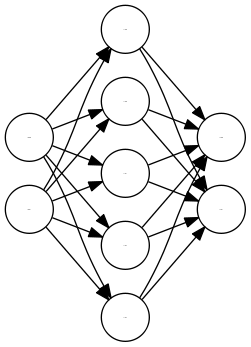

In [3]:
nn = NeuralNetwork(input_size=2, hidden_nodes=5, output_size=2)
nn.plot_model('graph.png')
Image('graph.png')

C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


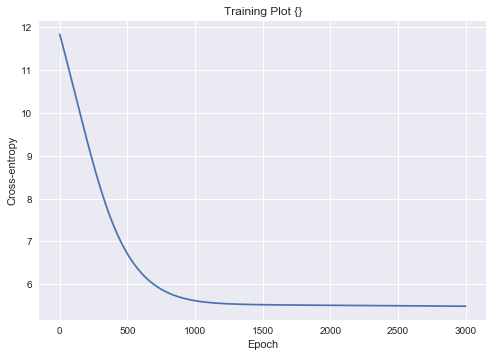

In [4]:
dataset = pd.DataFrame({
    'var1':   [0, 0, 1, 1],
    'var2':   [0, 1, 0, 1],
    'output': [0, 1, 1, 0],
})
dataset = pd.get_dummies(dataset, columns=['output'])
dataset['output'] = pd.Series([0, 1, 1, 0])

history = nn.fit(dataset[['var1','var2']].values, dataset[['output_0','output_1']].values, epochs=3000, lr=0.01)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}');


## Task 2

Now you will modify the class to allow the option to learn a regression model. You need to change some methods to account for the `mode` of the network. You can copy your code from task 1 as a starting point if you want.

If the `mode` is classification, you will use your code from Task1. In case of the `mode` being regression you will apply the `sigmoid` activation function to both layers and compute the deltas for that.

In [5]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        #TODO
        error = np.square(y_pred-y_true)
        error = error.mean()
        return error
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        #TODO
        cross_entropy = y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred)
        cross_entropy = cross_entropy.sum()*-1
        return cross_entropy
    
    @staticmethod
    def accuracy(y_pred, y_true):
        #TODO
        accuracy = (y_pred-y_true).mean()
        return accuracy
    
    @staticmethod
    def softmax(x):
        #TODO
        softmax = np.exp(x) / np.sum(np.exp(x), axis=0)
        return softmax
    
    @staticmethod
    def sigmoid(x):
        result=1 / (1 + np.exp(-x))
        #TODO
        return result
        
    def __init__(self, input_size, hidden_nodes, output_size,mode):
        '''Creates a Feed-Forward Neural Network.
        The parameters represent the number of nodes in each layer (total 3). 
        Look at the inputs to the function'''
        self.num_layers = 3 # includes input layer
        self.input_shape = input_size
        self.hidden_shape = hidden_nodes
        self.output_shape =output_size
        self.weights_ = self.biases_ = []
        self.mode=mode
        self.__init_weights()
    
    def __init_weights(self):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        #initialize hidden layer weight and bias
        W_h = np.random.normal(size = (self.hidden_shape, self.input_shape))
        b_h = np.zeros(shape = (self.hidden_shape,1))
        #initialize output layer weight and bias
        W_o = np.random.normal(size = (self.output_shape, self.hidden_shape))
        b_o = np.zeros(shape = (self.output_shape,1))
        self.weights_ = [W_h,W_o]
        self.biases_  = [b_h,b_o]
    
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        #for hidden layer z=W_h*x+b_h
        input_data = np.array(input_data)
        W_h = self.weights_[0]
        b_h = self.biases_[0]
        hidden_z = np.matmul(W_h, input_data.transpose()) + b_h
        hidden_z = NeuralNetwork.sigmoid(hidden_z)
        #for output layer z=W_o*hidden_z+b_o
        W_o = self.weights_[1]
        b_o = self.biases_[1]
        output_z = np.matmul(W_o, hidden_z) + b_o
        output_z = NeuralNetwork.sigmoid(output_z)
        activations = [hidden_z, output_z]
        #return activations in a list where each element of lists corresponds to a layer in network excluding input layer
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''   
        """f(x)(1-(f(x)))  derivative of softmax loss function"""
        """f(x) (1-f(x))  derivative of sigmoid loss function"""
        """deltas of output layer dl/dw=dl/dy* dy/dw  """
        """𝝓2=𝒂2−𝒚 𝒅𝒆𝒓𝒊𝒗2=𝒂2(1−𝒂2)  𝚫𝒘2=𝝓2⨀ 𝒅𝒆𝒓𝒊𝒗𝟐  𝝓1=(𝑾2(Δ𝑾2)𝑇)𝑇  𝒅𝒆𝒓𝒊𝒗1=𝒂1(1−𝒂1)  𝚫𝒘1=𝝓1⨀ 𝒅𝒆𝒓𝒊𝒗1"""
        #delta of output layer
        output_z = layer_activations[1]
        fie_output = 2 * (output_z - targets.transpose())
        deriv_output = np.multiply(output_z, 1 - output_z) 
        delta_output = np.multiply(fie_output, deriv_output)
        #delta of hidden layer
        hidden_z = layer_activations[0]
        output_weights = self.weights_[1]
        fie_hidden = np.matmul(output_weights.transpose(), delta_output)
        deriv_hidden = np.multiply(hidden_z, 1 - hidden_z)
        delta_hidden = np.multiply(fie_hidden, deriv_hidden)
        deltas = [delta_hidden, delta_output]
        #return deltas in list  where each element of lists corresponds to a weights of a layer in network excluding input layer
        return deltas

    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        #update the weight of output layer
        output_weights = self.weights_[1]
        new_output_weights = np.matmul(layer_inputs[1], deltas[1].transpose())
        new_output_weights = output_weights - lr * (new_output_weights.transpose())
        #update the bias of output layer
        output_bias = self.biases_[1]
        new_output_bias=output_bias-lr*np.sum(deltas[1])
        #update the weight of hidden layer
        hidden_weights = self.weights_[0]
        new_hidden_weights = np.matmul(layer_inputs[0].transpose(), deltas[0].transpose())
        new_hidden_weights = hidden_weights - lr * (new_hidden_weights.transpose())
        #update the bias of hidden layer
        hidden_bias = self.biases_[0]
        new_hidden_bias = hidden_bias - lr * np.sum(deltas[0])
        #set new weights and bias to the lists
        self.weights_ = [new_hidden_weights, new_output_weights]
        self.biases_ = [new_hidden_bias, new_output_bias]
        
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        for epoch in tqdm_notebook(range(epochs)):
            num_samples = Xs.shape[0]
            for i in range(num_samples):
                if(i+2 <= num_samples):
                    sample_input = Xs[i:i+2,:].reshape((1,self.input_shape))
                    sample_target = Ys[i,:].reshape((1,self.output_shape))
                
                    activations = self.forward_pass(sample_input)
                    deltas = self.backward_pass(sample_target, activations)

                    layer_inputs = [sample_input] + activations[:-1]
                    self.weight_update(deltas, layer_inputs, lr)

            preds = self.predict(Xs)
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys[:-1])
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys[:-1])
            history.append(current_loss)
        return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            if(i+2 <= num_samples):
                sample = Xs[i:i+2,:].reshape((1,self.input_shape))
                sample_prediction = self.forward_pass(sample)[-1]
                predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        nodes_per_layer = [self.input_shape, self.hidden_shape, self.output_shape]
        for i in range(self.num_layers-1):
            for n1 in range(nodes_per_layer[i]):
                for n2 in range(nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

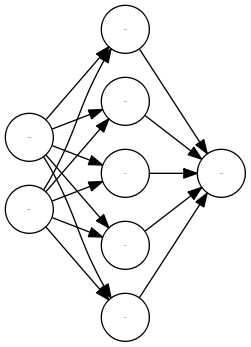

In [6]:
nn = NeuralNetwork(input_size=2, hidden_nodes=5, output_size=1, mode='regression')
nn.plot_model('graph.png')
Image('graph.png')

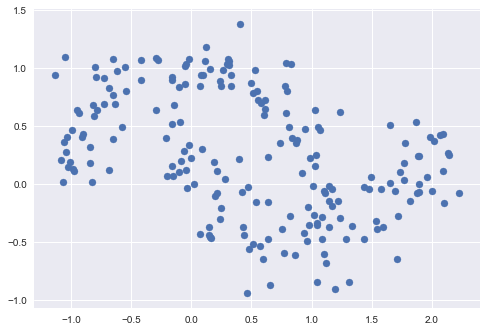

In [7]:
data_x, _ = make_moons(200, noise=0.18)
plt.scatter(data_x[:,0], data_x[:,1]);

In [8]:
reg = LinearRegression()
reg = reg.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));

d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = reg.predict(d)

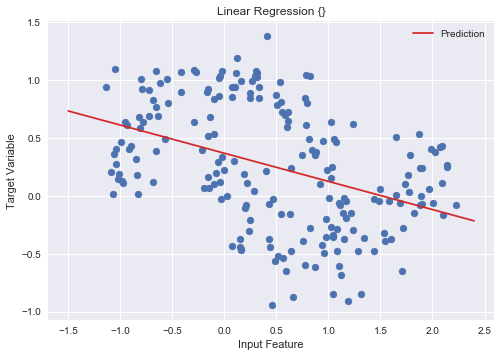

In [9]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Linear Regression {}');
ax.legend();

C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


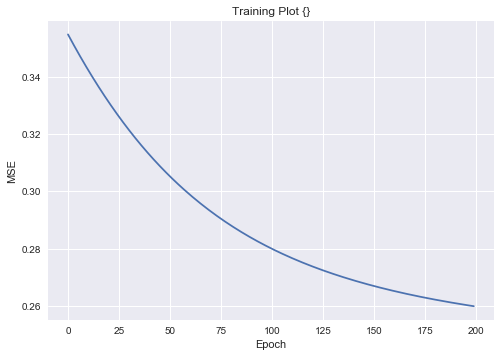

In [10]:
nn = NeuralNetwork(input_size=2, hidden_nodes=6, output_size=1, mode='regression')
history = nn.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)), epochs=200, lr=1e-4)
preds = nn.predict(d)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}');

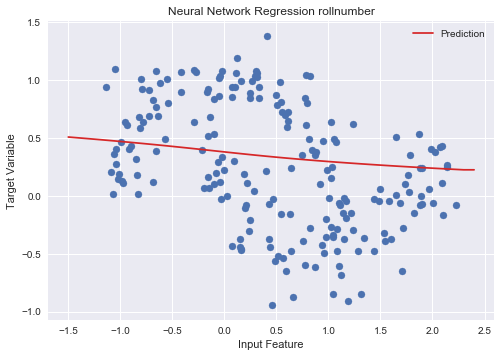

In [11]:
preds = np.append(preds, preds[-1])
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Neural Network Regression {}'.format("rollnumber"));
ax.legend();

## Task 3

Again, if it helps copy only your code from Task2 as a starting point in the next cell. Now you will modify the class to allow an arbitrarily shaped network. You will need to change all 3 primary methods.

*Hint: The output/last layer is special in terms of the delta calculation. All the hidden layers have the same calculation (chain rule)*

In [12]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        #TODO
        error = np.square(y_pred - y_true)
        error = error.mean()
        return error
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        #TODO
        cross_entropy = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
        cross_entropy=cross_entropy.sum() * -1
        return cross_entropy
    
    @staticmethod
    def accuracy(y_pred, y_true):
        #TODO
        accuracy = (y_pred - y_true).mean()
        return accuracy
    
    @staticmethod
    def softmax(x):
        #TODO
        softmax = np.exp(x) / np.sum(np.exp(x))
        return softmax
    
    @staticmethod
    def sigmoid(x):
        result = 1/(1 + np.exp(-x))
        #TODO
        return result
    
    def __init__(self, nodes_per_layer, mode):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have atleast 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        if mode not in ['classification','regression']:
            raise ValueError('Only "classification" and "regression" modes are supported.')
        
        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[len(nodes_per_layer)-1]
        self.mode = mode
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                # skip input layer, it does not have weights/bias
                continue
            
            weight_matrix = np.random.normal(size = (nodes_per_layer[i], nodes_per_layer[i-1]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape = (nodes_per_layer[i], 1))
            self.biases_.append(bias_vector)            

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations=[]
        input_data = input_data.transpose()
        for i in range(0,len(self.weights_)): #for number of layers
            weights = self.weights_[i]
            bias = self.biases_[i]
            z = np.matmul(weights, input_data) + bias
            #if mode is classification then the output layer which is len(self.weights_)-1 layer should compute softmax activation
            if i == len(self.weights_) - 1 and self.mode == "classification":
                z = NeuralNetwork.softmax(z)
            else:
                z = NeuralNetwork.sigmoid(z)
            activations.append(z)
            input_data = z
        #return activations in a list where each element of lists corresponds to a layer in network excluding input layer
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas=[]
        #for output layer the delta is calculated separately out of the loop because it is independent of other layers
        output_z = layer_activations[len(layer_activations) - 1]
        #derivative for softmax should be computer for output layer incase the mode is classification
        if self.mode == "classification":
            fie_output = output_z - targets.transpose()
        else:
            fie_output = 2*(output_z - targets.transpose())
        deriv_output = np.multiply(output_z, 1 - output_z) #elementwise multiplication
        delta_output = np.multiply(fie_output, deriv_output)
        #print(delta_output)
        next_layer_shape = len(output_z)
        deltas.append(delta_output)
        #for all other layers the delta is calculated using the deltas of the next layer in the network
        for i in range((len(layer_activations)) - 2, - 1, - 1):
            hidden_z = layer_activations[i]
            output_weights = self.weights_[i+1]
            fie_hidden = np.matmul(output_weights.transpose(), delta_output)
            deriv_hidden = np.multiply(hidden_z, 1-hidden_z)
            delta_hidden = np.multiply(fie_hidden, deriv_hidden)
            deltas.append(delta_hidden)
            delta_output = delta_hidden
        #reverse elements in the deltas list because since elements are calculated backwards so the last layer is instead at the 0 index 
        deltas = deltas[::-1]
        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        new_weights = []
        new_biases = []    
        for i in range(0, len(self.weights_)):
            output_weights = self.weights_[i]
            if i == 0:
                new_output_weights = np.matmul(layer_inputs[i].transpose(), deltas[i].transpose())
            else:
                new_output_weights = np.matmul(layer_inputs[i], deltas[i].transpose())
            new_output_weights = output_weights - lr * (new_output_weights.transpose())
            output_bias = self.biases_[i]
            new_output_bias = output_bias - lr * np.sum(deltas[i])
            new_weights.append(new_output_weights)
            new_biases.append(new_output_bias)
        #set new weights and biases to lists
        self.weights_ = new_weights
        self.biases_ = new_biases
    
    ## YOUR WORK ENDS HERE, LEAVE ALL FOLLOWING FUNCTIONS ALONE
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        print(Xs.shape)
        print(Ys.shape)
        for epoch in tqdm_notebook(range(epochs)):
            num_samples = Xs.shape[0]
            for i in range(num_samples):
                sample_input = Xs[i,:].reshape((1,self.input_shape))
                sample_target = Ys[i,:].reshape((1,self.output_shape))
                
                activations = self.forward_pass(sample_input)
                deltas = self.backward_pass(sample_target, activations)

                layer_inputs = [sample_input] + activations[:-1]
                self.weight_update(deltas, layer_inputs, lr)
            
            preds = self.predict(Xs)
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys)
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys)
            history.append(current_loss)
        return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

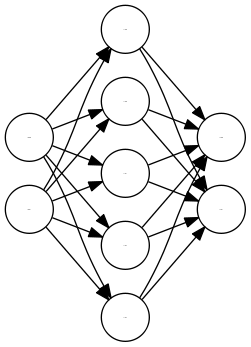

In [13]:
nn = NeuralNetwork([2,5,2], 'classification')
nn.plot_model('graph.png')
Image('graph.png')

(4, 2)
(4, 2)


C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


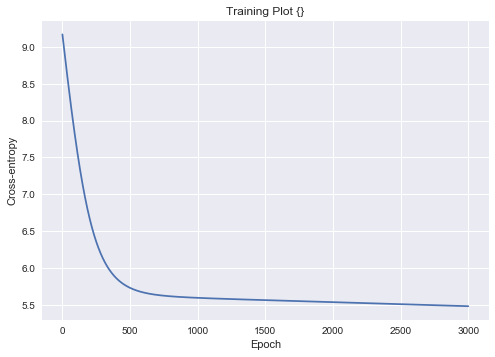

In [14]:
dataset = pd.DataFrame({
    'var1':   [0, 0, 1, 1],
    'var2':   [0, 1, 0, 1],
    'output': [0, 1, 1, 0],
})
dataset = pd.get_dummies(dataset, columns=['output'])
dataset['output'] = pd.Series([0, 1, 1, 0])

history = nn.fit(dataset[['var1','var2']].values, dataset[['output_0','output_1']].values, epochs=3000, lr=0.01)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}');


## Task 4

You should copy your code from task3 as a starting point. You have to modify the forward and backward passes to use a different activation function; the Rectified Linear Unit (ReLu). You can look at the research papers or articles online for derivatives and other explanations. 

In this task you need to implement the activation function and its derivative yourself. You can use a separate function for derivative of activation function or include the expression in the derivative calculation. 

No automatic test cases are included for this task. You should use the dummy tasks and look at the trend of the loss plot.

In [15]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        #TODO
        error = np.square(y_pred - y_true)
        error = error.mean()
        return error
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        #TODO
        cross_entropy = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
        cross_entropy = ( - cross_entropy).sum()
        return cross_entropy
    
    @staticmethod
    def accuracy(y_pred, y_true):
        #TODO
        accuracy = (y_pred - y_true).mean()
        return accuracy
    
    @staticmethod
    def relu(x):
        #TODO
        return np.maximum(x, 0)
    
    @staticmethod
    def relu_der(x):
        return np.greater(x, 0).astype(int)
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        for epoch in tqdm_notebook(range(epochs)):
            num_samples = Xs.shape[0]

            activations = self.forward_pass(Xs)
            deltas = self.backward_pass(Ys, activations)

            layer_inputs = [Xs] + activations[:-1]
            self.weight_update(deltas, layer_inputs, lr)
            
            preds = self.predict(Xs)
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys)
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys)
            history.append(current_loss)
        return history

    ## YOUR WORK STARTS HERE, YOU NEED TO LEAVE ALL THE OTHER FUNCTIONS AS THEY ARE
    
    def __init__(self, nodes_per_layer, mode):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have atleast 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        if mode not in ['classification','regression']:
            raise ValueError('Only "classification" and "regression" modes are supported.')
        
        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[len(nodes_per_layer)-1]
        self.mode = mode
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                # skip input layer, it does not have weights/bias
                continue
            
            weight_matrix = np.random.normal(size = (nodes_per_layer[i], nodes_per_layer[i-1]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape = (nodes_per_layer[i],1))
            self.biases_.append(bias_vector)

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        input_data = np.array(input_data)
        input_data = input_data.transpose()
        for i in range(0, len(self.weights_)): #for number of layers
            weights = self.weights_[i]
            bias = self.biases_[i]
            z = np.matmul(weights, input_data) + bias
            z = NeuralNetwork.relu(z)
            activations.append(z)
            input_data = z
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        
        deltas = []
        #for output layer the delta is calculated separately out of the loop because it is independent of other layers
        output_z = layer_activations[len(layer_activations) - 1]
        #if mode is classification then the output layer should compute softmax activation
        if self.mode == 'classification':
            fie_output = output_z - targets.transpose()
        else:
            fie_output = 2 * (output_z - targets.transpose())
        deriv_output = NeuralNetwork.relu_der(output_z)    
        delta_output = np.multiply(fie_output, deriv_output)
        deltas.append(delta_output)
        #for all other layers the delta is calculated using the deltas of the next layer in the network
        for i in range((len(layer_activations)) - 2, - 1, - 1):
            hidden_z = layer_activations[i]
            output_weights = self.weights_[i+1]
            fie_hidden = np.matmul(output_weights.transpose(), delta_output)
            deriv_hidden = NeuralNetwork.relu_der(hidden_z) 
            delta_hidden = np.multiply(fie_hidden, deriv_hidden)
            deltas.append(delta_hidden)
            delta_output=delta_hidden
        #reverse elements in the deltas list because since elements are calculated backwards so the last layer is instead at the 0 index
        deltas = deltas[::-1]
        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        new_weights = []
        new_biases = []
        #update weights of each layer in loop
        for i in range(0, len(self.weights_)):
            output_weights = self.weights_[i]
            if i == 0:
                new_output_weights = np.matmul(layer_inputs[i].transpose(), deltas[i].transpose())
            else:
                new_output_weights = np.matmul(layer_inputs[i], deltas[i].transpose())
            new_output_weights = output_weights - lr * (new_output_weights.transpose())
            output_bias = self.biases_[i]
            new_output_bias = output_bias - lr * np.sum(deltas[i])
            new_weights.append(new_output_weights)
            new_biases.append(new_output_bias)
        #set new weights and biases to list
        self.weights_ = new_weights
        self.biases = new_biases
    ## YOUR WORK ENDS HERE, LEAVE ALL FOLLOWING FUNCTIONS ALONE
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

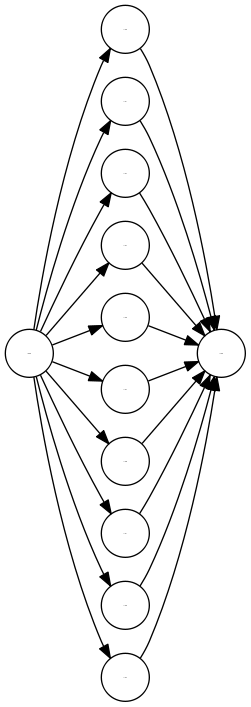

In [16]:
nn = NeuralNetwork([1,10,1], 'regression')
nn.plot_model('graph.png')
Image('graph.png')

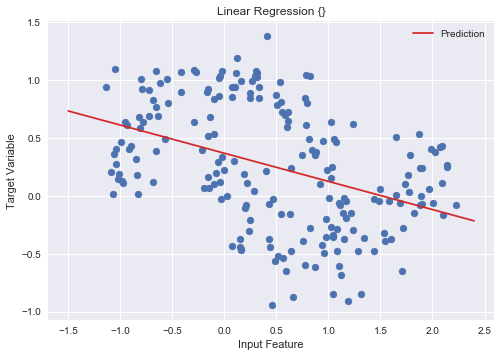

In [17]:
reg = LinearRegression()
reg = reg.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));

d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = reg.predict(d)


fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Linear Regression {}');
ax.legend();

C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


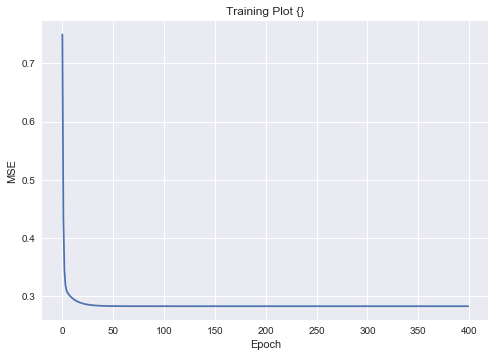

In [18]:
nn = NeuralNetwork([1,10,1], 'regression')
history = nn.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)), epochs=400, lr=1e-4)
preds = nn.predict(d)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}');

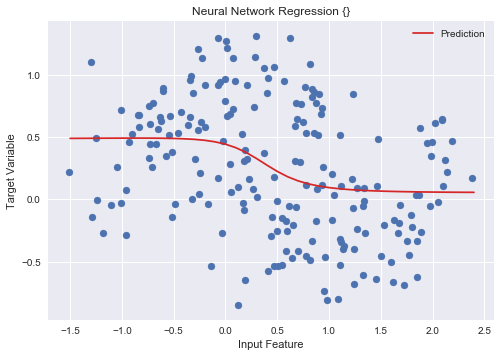

In [53]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Neural Network Regression {}');
ax.legend();

## Task 5

Again, if it helps copy only your code from Task3 as a starting point in the next cell. To cap off this assignment you will fully vectorize your implementation. This means changing the primary functions again. There is a handout to explain this further.

After you do this, the runtime of the `fit` function will just be $O(e)$ (again, assuming all functions called in the loop take constant time).

In [55]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        #TODO
        error = np.square(y_pred - y_true.transpose())               
        error = error.mean()
        return error
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        #TODO
        y = y_true
        cross_entropy = y * np.log(y_pred.transpose()) + (1 - y) * np.log(1 - y_pred.transpose())
        cross_entropy=(cross_entropy.sum()) * -1
        return cross_entropy
    
    @staticmethod
    def accuracy(y_pred, y_true):
        #TODO
        accuracy = (y_pred - y_true).mean()
        return accuracy
    
    @staticmethod
    def softmax(x):
        #TODO
        softmax = np.exp(x) / np.sum(np.exp(x), axis=0)
        return softmax
    
    @staticmethod
    def sigmoid(x):
        result = 1 / (1 + np.exp(-x))
        #TODO
        return result
    
    def __init__(self, nodes_per_layer, mode):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have atleast 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        if mode not in ['classification','regression']:
            raise ValueError('Only "classification" and "regression" modes are supported.')
        
        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[len(nodes_per_layer)-1]
        self.mode = mode
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                # skip input layer, it does not have weights/bias
                continue
            
            weight_matrix = np.random.normal(size = (nodes_per_layer[i], nodes_per_layer[i-1]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape = (nodes_per_layer[i],1))
            self.biases_.append(bias_vector)

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations=[]
        input_data = np.array(input_data)
        input_data = input_data.transpose()
        for i in range(0, len(self.weights_)): #for number of layers
            weights = self.weights_[i]
            bias = self.biases_[i]
            z = np.matmul(weights, input_data) + bias
            #if mode is classification then calculae softmax for output layer
            if i == len(self.weights_) - 1 and self.mode == "classification":
                z = NeuralNetwork.softmax(z)
            else:
                z = NeuralNetwork.sigmoid(z)
            activations.append(z)
            input_data = z
        #return activations in a list
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas=[]
        #for output layer the delta is calculated separately out of the loop because it is independent of other layers
        output_z = layer_activations[len(layer_activations) - 1]
        #if mode is classification then calculae derivative of softmax for output layer
        if self.mode == "classification":
            fie_output = (output_z - targets.transpose())
        else:
            fie_output = 2 * (output_z - targets.transpose())
             #elementwise multiplication
        deriv_output = np.multiply(output_z, 1 - output_z)
        delta_output = np.multiply(fie_output, deriv_output)
        deltas.append(delta_output)
        #for all other layers the delta is calculated using the deltas of the next layer in the network
        for i in range((len(layer_activations)) - 2, - 1, - 1):
            hidden_z = layer_activations[i]
            output_weights = self.weights_[i+1]
            fie_hidden = np.matmul(output_weights.transpose(), delta_output)
            deriv_hidden = np.multiply(hidden_z, 1 - hidden_z)
            delta_hidden = np.multiply(fie_hidden, deriv_hidden)
            deltas.append(delta_hidden)
            delta_output=delta_hidden
        #reverse elements in the deltas list because since elements are calculated backwards so the last layer is instead at the 0 index
        deltas = deltas[::-1]
        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        new_weights = []
        new_biases = []
        for i in range(0, len(self.weights_)):
            output_weights = self.weights_[i]
            if i == 0:
                new_output_weights = np.matmul(layer_inputs[i].transpose(), deltas[i].transpose())
            else:
                new_output_weights = np.matmul(layer_inputs[i], deltas[i].transpose())
            new_output_weights = output_weights - lr * (new_output_weights.transpose())
            output_bias = self.biases_[i]
            new_output_bias = output_bias - lr * np.sum(deltas[i])
            new_weights.append(new_output_weights)
            new_biases.append(new_output_bias)
        #set new weights and biases to the list
        self.weights_ = new_weights
        self.biases = new_biases

    ## YOUR WORK ENDS HERE, LEAVE ALL FOLLOWING FUNCTIONS ALONE
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        for epoch in tqdm_notebook(range(epochs)):
            num_samples = Xs.shape[0]
            sample_input = Xs
            sample_target = Ys

            activations = self.forward_pass(sample_input)
            deltas = self.backward_pass(sample_target, activations)

            layer_inputs = [sample_input] + activations[:-1]
            self.weight_update(deltas, layer_inputs, lr)
            
            preds = self.predict(Xs)
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys)
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys)
            history.append(current_loss)
        return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        return self.forward_pass(Xs)[-1]
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

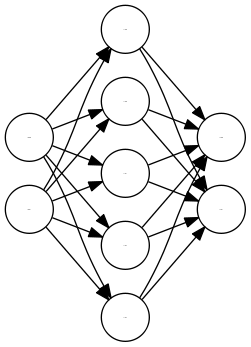

In [56]:
nn = NeuralNetwork([2,5,2], 'classification')
nn.plot_model('graph.png')
Image('graph.png')

In [57]:
reg = LinearRegression()
reg = reg.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));

d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = reg.predict(d)

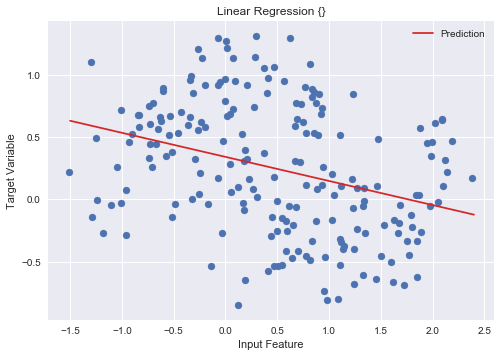

In [58]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Linear Regression {}');
ax.legend();

C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


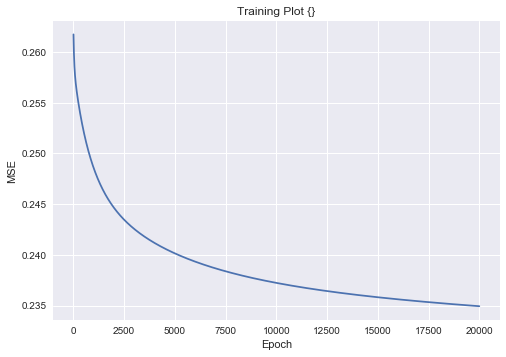

In [60]:
nn = NeuralNetwork([1,10,20,10,1], 'regression')
history = nn.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)), epochs=20000, lr=1e-4)
preds = nn.predict(d)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}');

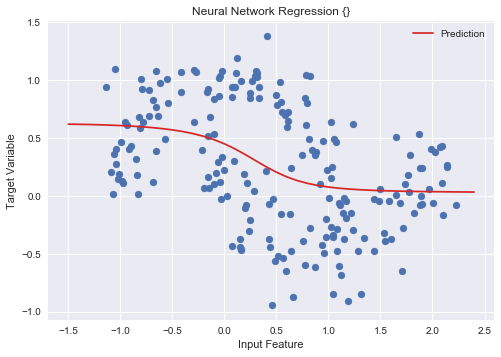

In [25]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Neural Network Regression {}');
ax.legend();

## Dummy Regression Task

In [65]:
a = np.random.uniform(low=0.0, high=0.5, size=(150,))
b = np.random.uniform(low=0.0, high=0.5, size=(150,))
dataset = pd.DataFrame({
    'var1':   a,
    'var2':   b,
    'output': a+b,
})
print(dataset.shape)
dataset.head()

(150, 3)


,var1,var2,output
0,0.051741,0.470620,0.522360
1,0.413540,0.160853,0.574394
2,0.438926,0.355223,0.794149
3,0.204528,0.062534,0.267062
4,0.091812,0.217520,0.309332


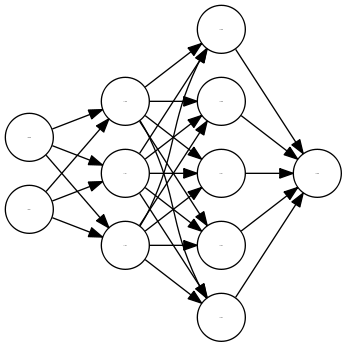

In [66]:
nn = NeuralNetwork([2,3,5,1], 'regression')
nn.plot_model('graph.png')
Image('graph.png')

C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


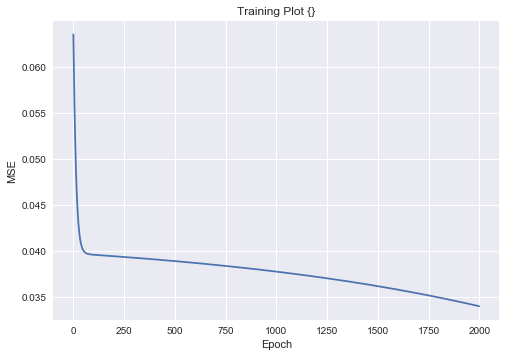

In [67]:
history = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, epochs=2000, lr=0.001)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}');

In [48]:
test_data = np.array([[0.4,0.1],
                      [0.2,0.3]])
nn.predict(test_data)

array([[0.56006291, 0.80714574],
       [0.43993709, 0.19285426]])

## Dummy Classification Task

In [68]:
# XOR logic operator
dataset = pd.DataFrame({
    'var1':   [0, 0, 1, 1],
    'var2':   [0, 1, 0, 1],
    'output': [0, 1, 1, 0],
})
dataset = pd.get_dummies(dataset, columns=['output'])
dataset['output'] = pd.Series([0, 1, 1, 0])
print(dataset.shape)
dataset.head()
# The columns 'output_0' and 'output_1' are one-hot encoded representation of the categorical column 'output'

(4, 5)


,var1,var2,output_0,output_1,output
0,0,0,1,0,0
1,0,1,0,1,1
2,1,0,0,1,1
3,1,1,1,0,0


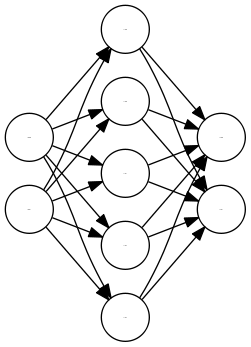

In [69]:
nn = NeuralNetwork([2,5,2], 'classification')
nn.plot_model('graph.png')
Image('graph.png')

C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


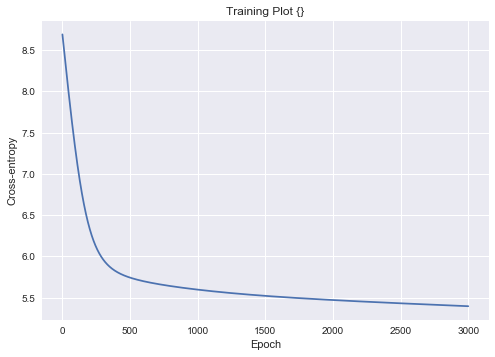

In [70]:
history = nn.fit(dataset[['var1','var2']].values, dataset[['output_0','output_1']].values, epochs=3000, lr=0.01)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}');

In [71]:
nn.predict(dataset[['var1','var2']].values).argmax(axis=1) == dataset[['output_0','output_1']].values.argmax(axis=1)

C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

## Regression Demo

Code for Demos adapted from tutorial 1, refer to it if you need a refresher (available on LMS)

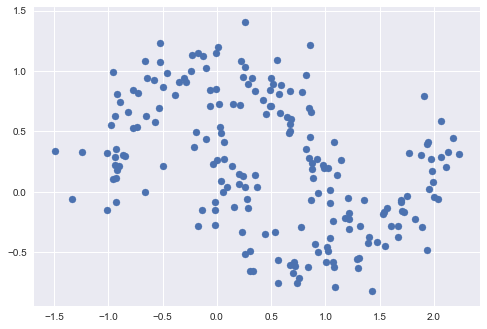

In [72]:
data_x, _ = make_moons(200, noise=0.18)
plt.scatter(data_x[:,0], data_x[:,1]);

In [73]:
reg = LinearRegression()
reg = reg.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));

d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = reg.predict(d)

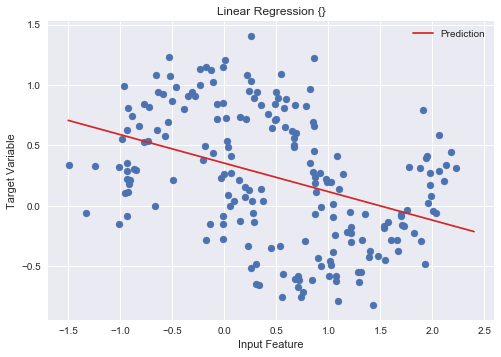

In [74]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Linear Regression {}');
ax.legend();

C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


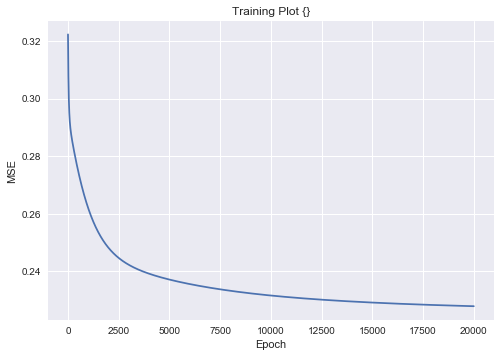

In [75]:
nn = NeuralNetwork([1,10,20,10,1], 'regression')
history = nn.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)), epochs=20000, lr=1e-4)
preds = nn.predict(d)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}');

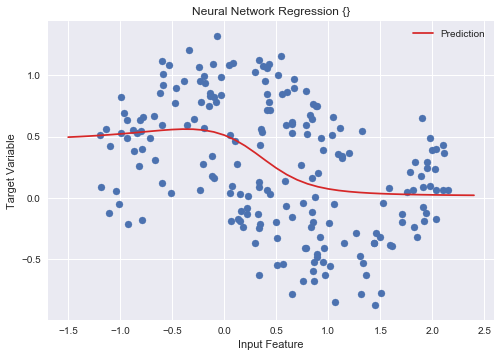

In [38]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Neural Network Regression {}');
ax.legend();

## Classification Demo

In [39]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry
def plot_decision_boundary(pred_func, x_min, x_max, y_min, y_max, cmap, ax):
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)
    # Plot the contour
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

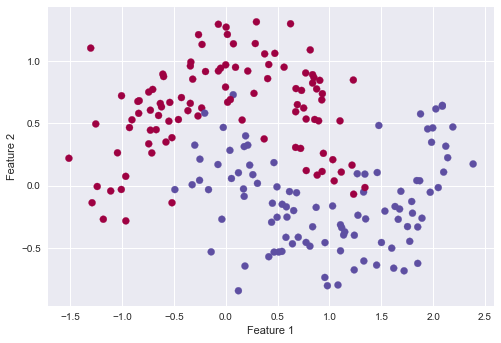

In [40]:
data_x, data_y = make_moons(200, noise=0.20)
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2');

In [41]:
clf = LogisticRegression(solver='lbfgs')
clf = clf.fit(data_x, data_y);

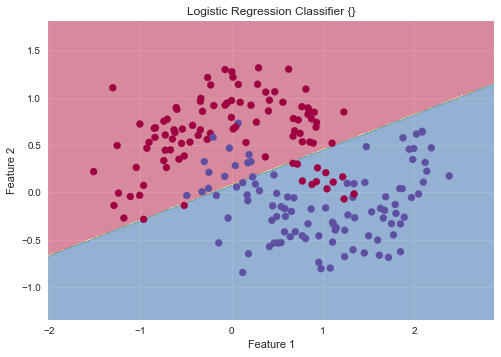

In [42]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: clf.predict(x), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title='Logistic Regression Classifier {}');

C:\Users\MAQS\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


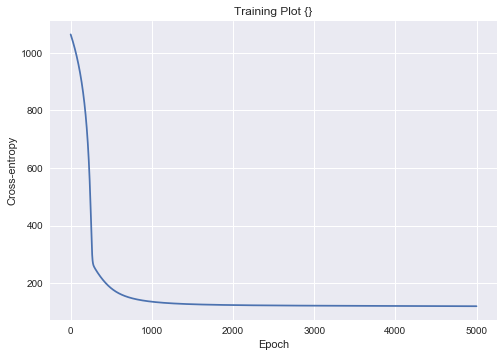

In [43]:
nn = NeuralNetwork([2,10,10,2], 'classification')
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=5000, lr=1e-3)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}');

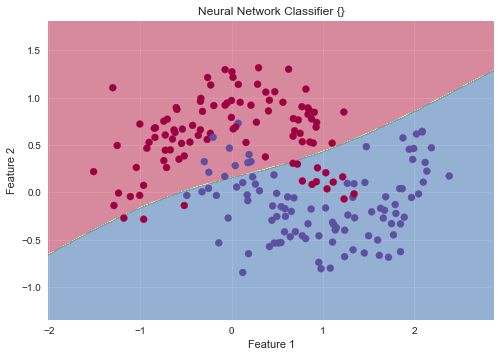

In [44]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=0), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title='Neural Network Classifier {}');